In [19]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from scipy import stats

df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")

In [72]:
############### Making a balanced dataframe #################
'''random.seed(1)

df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")
pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
df_neg_only = neg.sample(n=len(pos), random_state =1)
#df_pos_only = pos.sample(n=1500, random_state =1)


df_emotion = pd.concat([df_neg_only, pos])'''

pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
df_neg_only = neg.sample(n=1500, random_state =1)
df_pos_only = pos.sample(n=1500, random_state =1)


df_emotion = pd.concat([df_neg_only, df_pos_only])

In [73]:
######### to make sure two datasets have the same original reviews ##########
'''df_time_adj = pd.read_csv("LIWC2015 Results (previous_reviews.csv).csv")
df_time_adj.rename(columns={'K':'originalRevID','A': 'date', 'B': 'reviewID', 'C':'reviewerID', 'D': 'review', 'E': 'rating', 'F':'usefulCount', 'G':'coolCount','H':'funnyCount', 'I': 'flagged','J': 'restaurantID'}, inplace=True)
df_time_adj=df_time_adj.drop(0)

rev_ids = df_time_adj["originalRevID"]'''

df_time_adj = pd.read_csv("time_adjusted_LIWC_and_emotions.csv")
#df_time_adj.rename(columns={'K':'originalRevID','A': 'date', 'B': 'reviewID', 'C':'reviewerID', 'D': 'review', 'E': 'rating', 'F':'usefulCount', 'G':'coolCount','H':'funnyCount', 'I': 'flagged','J': 'restaurantID'}, inplace=True)
#df_time_adj=df_time_adj.drop(0)

rev_ids = df_time_adj["originalRevID"]



df_emotion = df_emotion[df_emotion['reviewID'].isin(rev_ids)]

In [74]:
df_base = df_emotion[["restaurantID","rating","Tone","Analytic","Clout","Authentic",
                      "WC","flagged","i","we","you","shehe","they","ipron",
                      "anger","sadness","disgust","fear","joy"]]
#df_base = df_emotion[["rating","Tone","Analytic","Clout","Authentic","WC","flagged"]]

In [75]:
import sqlite3

def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connect_db("/Users/jamesfyfe/summer vac misc/yelpResData.db")
cur = conn.cursor()


res_ids = tuple(df_base["restaurantID"].unique())
query = "SELECT restaurantID,rating FROM restaurant WHERE restaurantID in {}".format(res_ids)
cur.execute(query)
res_ratings = cur.fetchall()

In [76]:
df_res = pd.DataFrame(res_ratings).rename(columns={1:"resRating",0:"restaurantID"})
df_base = pd.merge(df_base,df_res, on="restaurantID").drop(columns=["restaurantID"])
df_base["ratingDiffOriginal"] = np.abs(df_base["rating"] - df_base["resRating"])


In [77]:
df_base=df_base.drop(columns=["rating","resRating"])

Optimization terminated successfully.
         Current function value: 0.632575
         Iterations 5

Train Accuracy: 0.6379958246346555

Test Accuracy: 0.6343906510851419
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                 2395
Model:                          Logit   Df Residuals:                     2377
Method:                           MLE   Df Model:                           17
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                 0.08739
Time:                        14:39:24   Log-Likelihood:                -1515.0
converged:                       True   LL-Null:                       -1660.1
Covariance Type:            nonrobust   LLR p-value:                 1.213e-51
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                

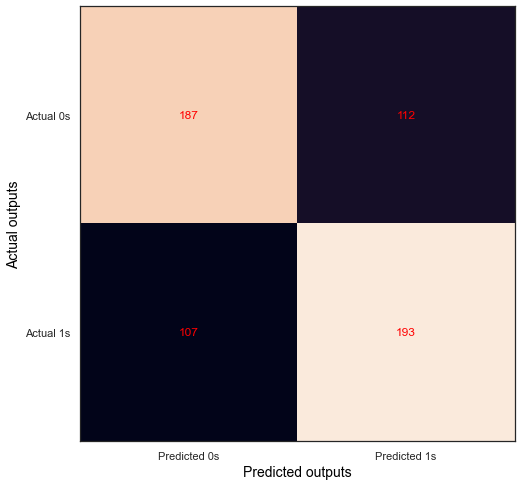

In [78]:
from sklearn.preprocessing import StandardScaler

def logit_regression(df_reg_emotion):
    le_emotion = preprocessing.LabelEncoder()
    df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

    X = df_reg_emotion.drop(columns=["flagged"])
    X = sm.add_constant(X)
    Y = df_reg_emotion["flagged"]

    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

    model = sm.Logit(Y_train, X_train)
    result = model.fit()
    
    print("\nTrain Accuracy: " + str(sum((result.predict(X_train) >= 0.5).astype(int) == Y_train)/len(Y_train)))
    print("\nTest Accuracy: " + str(sum((result.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
    print(result.summary())
    print(classification_report(Y_test, (result.predict(X_test) >= 0.5).astype(int)))
    cm = confusion_matrix(Y_test, (result.predict(X_test) >= 0.5).astype(int))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
    ax.set_ylabel('Actual outputs', fontsize=14, color='black')
    ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

logit_regression(df_base)

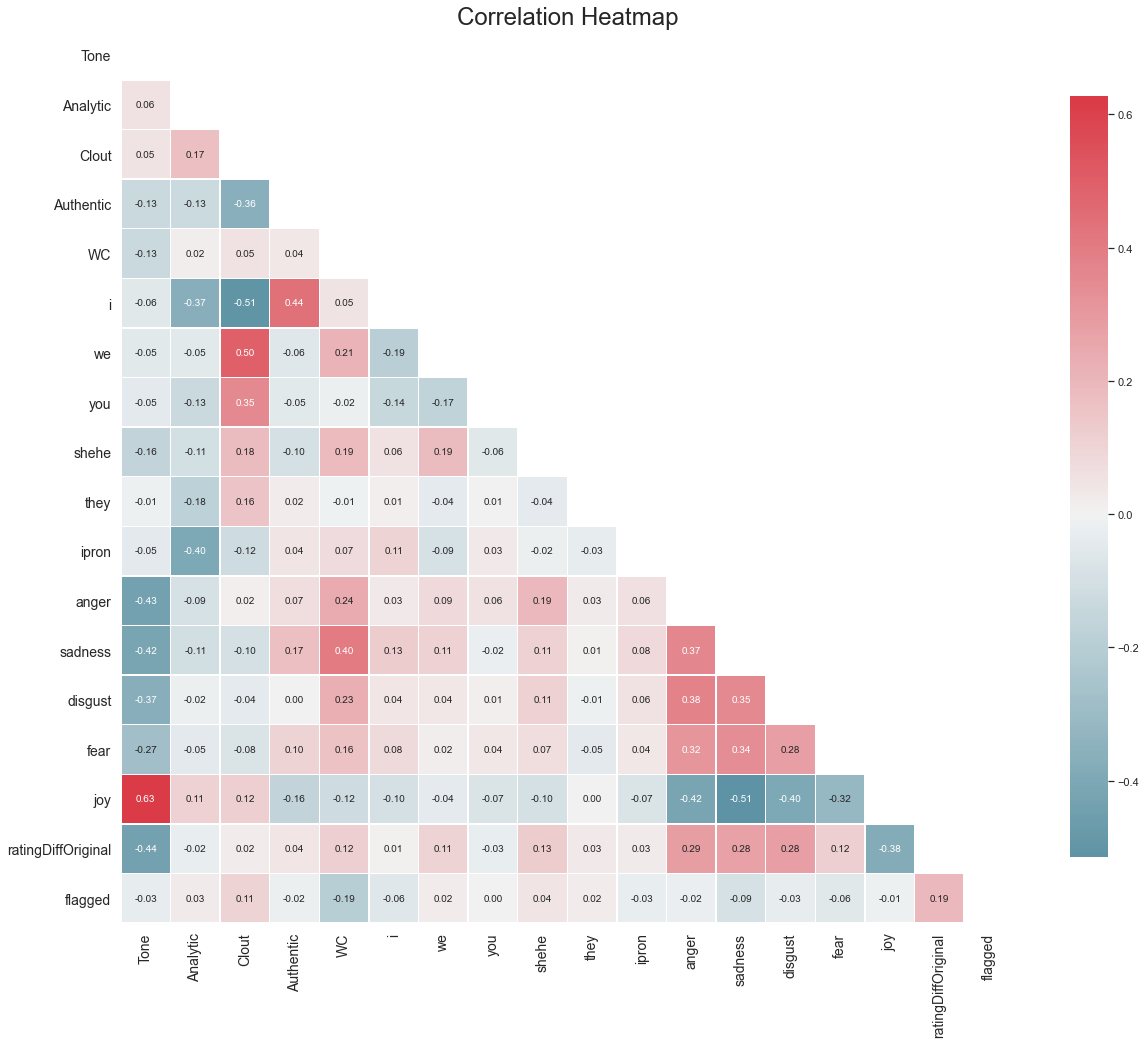

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_fs):
    sns.set(style="white")
    # Calculating Pearson's correlation coefficient of the subsetted data
    correlation = (pd.concat([df_fs.drop(columns=["flagged"]),df_fs["flagged"]], axis=1)).corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, center=0, mask=mask,cmap=cmap,
                fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .70},  
                annot_kws={"size": 10})
    ax.set_title('Correlation Heatmap', fontsize = 24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

    
heatmap(df_base)